In [17]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Categorical
from collections import deque
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
%matplotlib inline

* `Loss for critic network`: $\delta^2 = (r(s,a) + \gamma*V(S') - V(S))^2$
* `Loss for actor netwrok`: $\delta*ln(\pi(a|s)$) 

## Overview of algorithm
1. Initialiaze actor critic algorithm
2. FOR Large number of episodes:
   * Reset Env, score, terminal flag
   * While state is not terminal:
     * Select action acoring to actor network
     * Take action and receive new reward and state
     * calculate $\delta$

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
class ACNET(nn.Module):
    
    def __init__(self, n_actions, feature_space):
        super(ACNET, self).__init__()
        self.n_actions = n_actions
        self.HIDDEN = 256
        self.layer1 = nn.Linear(in_features=feature_space, out_features= self.HIDDEN)
        self.layer2 = nn.Linear(in_features= self.HIDDEN, out_features= self.HIDDEN)
        self.ReLU = nn.ReLU()
        self.value = nn.Linear(in_features = self.HIDDEN, out_features=1)
        self.pi = nn.Linear(in_features= self.HIDDEN, out_features= n_actions)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x =  self.layer2(self.ReLU(self.layer2(self.ReLU(self.layer1(x)))))
        value = self.value(x)
        pi = self.softmax(self.pi(x))
        
        return value, pi
        

In [97]:
class Agent:
    
    def __init__(self, n_actions, feature_space):
        self.discout_factor = 1.0
        self.lr = 5e-1
        self.n_actions = n_actions
        self.prev_action = None
        self.action_space = np.arange(self.n_actions)
        self.network = ACNET(n_actions=n_actions, feature_space=feature_space)
        self.optimizer = torch.optim.Adagrad(params=self.network.parameters(), lr=self.lr, lr_decay=1e-3)
        
    
    
    def action_selection(self, observation):
        observation = torch.tensor(observation)
        with torch.inference_mode():   
            value, probs = self.network(observation)
            action_probs = Categorical(probs=probs)
            sampled_action = action_probs.sample()
            self.prev_action = sampled_action
            return sampled_action.item()
    
    def learn(self, state, reward, new_state, done):
        state = torch.tensor(state)
        new_state = torch.tensor(new_state)
        reward = torch.tensor(reward)
        
        # FORWARD PASS
        self.network.train()
        state_val, probs = self.network(state)
        new_state_val, _ = self.network(new_state)
        
        # calculate the loss
        action_probs = Categorical(probs=probs)
        log_probs = action_probs.log_prob(self.prev_action)
        
        delta = reward + new_state_val*self.discount_factor*(1-int(done)) - state_val
        
        critic_loss = delta**2
        actor_loss = delta*log_probs
        
        # reset grad value to None
        self.optimizer.zero_grad()
        
        # bakprop the losses
        critic_loss.backward(retain_graph=True)
        actor_loss.backward(retain_graph=True)
        
        # update the weights
        self.optimizer.step()
        

In [98]:
class CATCHTHEBALL:
    def __init__(self, N: int):
        self.size = N
        self.frame = np.zeros(shape = (N, N), dtype = np.int8)
        self.moving_down = 1 # If the ball is moving down
        self.deviation_left = 1 # whether balls moving in left or right 1 -> left deviation
        self.ball_position = [ 1 , np.random.randint(N//4, N//2)]
        self.plate_position = [ N-2 , np.random.randint(1, N - 2)]
    def ballMove(self):
        N = self.size
        # if ball is by the wall then the deviatin changes and move according to
        if tuple(self.ball_position) == tuple([self.plate_position[0] -1 ,self.plate_position[1]]): # just above the plate
            if self.ball_position[1] == 1 or self.ball_position[1] == N - 2: # edge
                self.moving_down = -1 # going up
            else:
                self.moving_down = - 1
                self.deviation_left = -1*self.deviation_left
        elif self.ball_position[0] == 1 and (self.ball_position[1] == 1 or self.ball_position[1] == N-2) and self.moving_down==-1:# exaxt edge
            if self.ball_position[1] == 1:               
                self.deviation_left = -1
            else:
                self.deviation_left = 1
            self.moving_down = 1
                
        elif self.ball_position[1] == 1 or self.ball_position[1] == N-2: #
            self.deviation_left = -1*self.deviation_left
        
        elif self.ball_position[0] == 1 and self.moving_down == -1:# going up and edge
            if self.ball_position[1] == 1 or self.ball_position[1] == N - 2: # edge
                self.moving_down = 1 # going up
            else:
                self.moving_down =  1
                self.deviation_left = -1*self.deviation_left
            
        
        # move now
        self.ball_position[0] += self.moving_down
        self.ball_position[1] -= self.deviation_left*self.moving_down
        
    
    def movePlate(self, action : int): # 0-> left 1->right 2-> nothing
        if action == 0: # move left
            if self.plate_position[1] == 1: # in the edge and move left
                self.plate_position[1] += 1
            else:
                
                self.plate_position[1] -= 1    
        elif action == 1:
            if self.plate_position[1] == self.size - 2:
                self.plate_position[1] -= 1
            else:
                
                self.plate_position[1] += 1    
    
    def getFeature(self): # [relative position, going_up, left_directed], reward, done
        
        pos = [self.ball_position[0] - self.plate_position[0], self.ball_position[1] - self.plate_position[1], 
              self.moving_down, self.deviation_left]
        if self.ball_position[0] == self.size - 2:
            return pos, 0, 1
        elif tuple(self.ball_position) == tuple([self.plate_position[0] -1 ,self.plate_position[1]]):
            return pos, 1, 0
        else:
            return pos, 0, 0
                                                
        
    def showFrame(self):
        # present ball as `o` and `_` plate
        for i in range(self.size):
            for j in range(self.size):
                if i == 0 or i == self.size - 1 or j == 0 or j == self.size - 1:
                    print('*', end = ' ')
                elif tuple(self.ball_position) == (i, j):
                    print('o', end = ' ')
                elif tuple(self.plate_position) == (i, j):
                    print('-', end = ' ')
                else:
                    print(' ', end = ' ')
            print()        

In [99]:
agent = Agent(n_actions=3, feature_space= 4)

In [100]:
score_history = []
succes_history = []
success = 0 
n_games = 30000
for episode in range(n_games):
    env = CATCHTHEBALL(10)
    observation = np.array(env.getFeature()[0], dtype = np.float32)
    done = False
    score = 0
    max_step = 100

    while not done and max_step:
        action = agent.action_selection(observation)
        env.movePlate(action)
        env.ballMove()
        observation_, reward, done = env.getFeature()
        score += reward
        observation = np.array(observation_, dtype = np.float32)
        max_step -= 1
        if reward == 1:
            success += 1
    score_history.append(score)
    succes_history.append(success)
    avg_score = np.mean(score_history[-100:])
    
    if episode % 100== 0:
        #agent.optimizer = torch.optim.Adagrad(params=agent.network.parameters(), lr=agent.lr*0.9999)
        print(f'episode  {episode} score  {score} avg_score  {avg_score:.2f} success {success}')


episode  0 score  0 avg_score  0.00 success 0
episode  100 score  0 avg_score  0.16 success 16
episode  200 score  0 avg_score  0.21 success 37
episode  300 score  0 avg_score  0.17 success 54
episode  400 score  0 avg_score  0.12 success 66
episode  500 score  0 avg_score  0.18 success 84
episode  600 score  0 avg_score  0.21 success 105
episode  700 score  0 avg_score  0.20 success 125
episode  800 score  0 avg_score  0.18 success 143
episode  900 score  0 avg_score  0.18 success 161
episode  1000 score  1 avg_score  0.18 success 179
episode  1100 score  0 avg_score  0.14 success 193
episode  1200 score  0 avg_score  0.12 success 205
episode  1300 score  0 avg_score  0.15 success 220
episode  1400 score  0 avg_score  0.20 success 240
episode  1500 score  0 avg_score  0.20 success 260
episode  1600 score  0 avg_score  0.11 success 271
episode  1700 score  0 avg_score  0.26 success 297
episode  1800 score  0 avg_score  0.17 success 314
episode  1900 score  0 avg_score  0.16 success 330

episode  15900 score  0 avg_score  0.16 success 2478
episode  16000 score  0 avg_score  0.15 success 2493
episode  16100 score  1 avg_score  0.15 success 2508
episode  16200 score  1 avg_score  0.20 success 2528
episode  16300 score  1 avg_score  0.16 success 2544
episode  16400 score  1 avg_score  0.16 success 2560
episode  16500 score  0 avg_score  0.16 success 2576
episode  16600 score  0 avg_score  0.16 success 2592
episode  16700 score  0 avg_score  0.18 success 2610
episode  16800 score  0 avg_score  0.12 success 2622
episode  16900 score  0 avg_score  0.17 success 2639
episode  17000 score  0 avg_score  0.17 success 2656
episode  17100 score  0 avg_score  0.16 success 2672
episode  17200 score  0 avg_score  0.14 success 2686
episode  17300 score  1 avg_score  0.17 success 2703
episode  17400 score  0 avg_score  0.16 success 2719
episode  17500 score  0 avg_score  0.16 success 2735
episode  17600 score  1 avg_score  0.21 success 2756
episode  17700 score  0 avg_score  0.19 succes

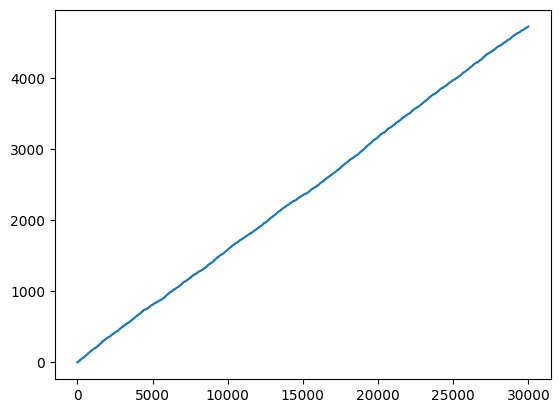

In [101]:
plt.plot(np.arange(n_games), succes_history)